In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import torch
import json
import pandas as pd
import gc as gc
import numpy as np
from datasets import Dataset
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import statistics

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [16]:
TRAIN_JSON_FILE = "../data/train.json"
DEV_JSON_FILE = "../data/dev.json"
OUTPUT_DIR = "../deberta-finetune-2"

In [17]:
def load_data(file_path):
    """
    Loads the json containing the dataset and return a pandas dataframe.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    # Transpose because the json is {id: {features...}, ...}
    df = pd.DataFrame(data).T
    # Ensure 'average' is float
    df['average'] = df['average'].astype(float)
    # Ensure 'choices' is list (for scoring later)
    return df

df_train = load_data(TRAIN_JSON_FILE)
df_dev = load_data(DEV_JSON_FILE)

# Convert to HF Dataset
# We keep the index as 'id' column
df_train['id'] = df_train.index
df_dev['id'] = df_dev.index

full_train_dataset = Dataset.from_pandas(df_train)
dev_dataset = Dataset.from_pandas(df_dev)

# Split train_dataset into train and validation (e.g., 10% for validation)
# This ensures the model doesn't see the dev set during training
train_val_split = full_train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_split['train']
eval_dataset = train_val_split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Eval (from Train) size: {len(eval_dataset)}")
print(f"Dev (Holdout) size: {len(dev_dataset)}")

Train size: 2052
Eval (from Train) size: 228
Dev (Holdout) size: 588


In [18]:
df_train.head()

,homonym,judged_meaning,precontext,sentence,ending,choices,average,stdev,nonsensical,sample_id,example_sentence,id
0,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[4, 5, 2, 3, 1]",3.0,1.581139,"[False, False, False, False, False]",1843,The circuit has a high potential difference.,0
1,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[5, 3, 4, 4, 3]",3.8,0.83666,"[False, False, False, False, False]",1844,The project has great potential for success.,1
2,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[2, 1, 4, 3, 1]",2.2,1.30384,"[False, False, False, False, False]",1845,The circuit has a high potential difference.,2
3,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[4, 5, 5, 3, 5]",4.4,0.894427,"[False, False, False, False, False]",1846,The project has great potential for success.,3
4,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,,"[1, 1, 4, 4, 3]",2.6,1.516575,"[False, False, False, False, False]",1847,The circuit has a high potential difference.,4


In [19]:
model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
def preprocess_function(data):
    """
    Construct tokenized Premise and Hypothesis for the NLI model.
    Premise: {precontext} {sentence} {ending}
    Hypothesis: The definition of "{homonym}" is: "{judged_meaning}" as in the following sentence: "{example_sentence}"
    """

    premises = [
        f"{p} {s} {e}" for p, s, e in zip(data['precontext'], data['sentence'], data['ending'])
    ]
    hypotheses = [
        f'The definition of "{h}" is: "{j}" as in the following sentence: "{ex}"' 
        for h, j, ex in zip(data['homonym'], data['judged_meaning'], data['example_sentence'])
    ]
    
    # Tokenize
    # REMOVED padding="max_length" to save memory and allow dynamic padding
    model_inputs = tokenizer(premises, hypotheses, max_length=128, truncation=True)
    
    # Labels: 'average' column
    # Scale to 0-1 based on range 0.5 - 5.5
    model_inputs["labels"] = [(x - 0.5) / 5.0 for x in data["average"]]
    
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)
tokenized_dev = dev_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 588/588 [00:00<00:00, 11053.82 examples/s]


In [21]:
# Check token lengths
# Here max_length is set to 128. But if you don't set it in the cell above you'll get the real results.
lengths = [len(x) for x in tokenized_train['input_ids']]
print(f"Max length: {max(lengths)}")
print(f"Average length: {sum(lengths)/len(lengths)}")
import pandas as pd
print(pd.Series(lengths).describe(percentiles=[0.9, 0.95, 0.99]))

Max length: 128
Average length: 96.64083820662768
count    2052.000000
mean       96.640838
std        13.212074
min        63.000000
50%        96.000000
90%       114.000000
95%       120.000000
99%       128.000000
max       128.000000
dtype: float64


In [22]:
# Load model for regression (num_labels=1)
# We need ignore_mismatched_sizes=True because the pretrained model has 3 labels (NLI)
# and we are resizing the head to 1 label (regression).
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=1, 
    problem_type="regression",
    ignore_mismatched_sizes=True
)
model.to(device)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

In [23]:
# Clear cache to free up fragmented memory
torch.cuda.empty_cache()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    
    # Rescale predictions to 0.5 - 5.5
    predictions = predictions * 5.0 + 0.5
    
    # Check if we are evaluating on the validation set
    # The error (588 vs 228) confirms we were trying to use eval_dataset (228) 
    # while predicting on dev_dataset (588).
    if len(predictions) == len(eval_dataset):
        gold_choices = eval_dataset['choices']
        gold_averages = eval_dataset['average']
    else:
        # Fallback for other datasets (like dev_dataset) where we might not have 'choices' readily available
        # or the length doesn't match eval_dataset.
        # We use the labels passed to the function (which are scaled 0-1) and rescale them.
        gold_choices = None
        gold_averages = labels * 5.0 + 0.5
    
    # Spearman
    spearman_corr, _ = spearmanr(predictions, gold_averages)
    
    metrics = {"spearman": spearman_corr}

    # Accuracy (only if we have choices)
    if gold_choices is not None:
        accuracies = []
        for pred, choices in zip(predictions, gold_choices):
            avg = sum(choices)/len(choices)
            stdev = statistics.stdev(choices)
            if (avg - stdev) < pred < (avg + stdev):
                accuracies.append(1)
            elif abs(avg - pred) < 1:
                accuracies.append(1)
            else:
                accuracies.append(0)
        accuracy = sum(accuracies) / len(accuracies)
        metrics["accuracy"] = accuracy
        metrics["combined_score"] = (spearman_corr + accuracy) / 2
    else:
        metrics["combined_score"] = spearman_corr

    return metrics

training_args = TrainingArguments(
    output_dir=f"{OUTPUT_DIR}/model/",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    logging_dir=f"{OUTPUT_DIR}/logs/",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="combined_score",
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    # Below three are same as the finetuning of the model used
    warmup_ratio=0.06,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    fp16=True       ,                 # mixed precision trainingd
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    optim="adafactor"                # Switch to Adafactor to save memory
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Spearman,Accuracy,Combined Score
1,0.038700,0.061465,0.567173,0.614035,0.590604
2,0.034500,0.039971,0.655110,0.780702,0.717906
3,0.019300,0.034321,0.688402,0.837719,0.763061
4,0.011100,0.033926,0.697668,0.837719,0.767693


TrainOutput(global_step=1028, training_loss=0.03923768655248421, metrics={'train_runtime': 539.8457, 'train_samples_per_second': 15.204, 'train_steps_per_second': 1.904, 'total_flos': 1652370844277928.0, 'train_loss': 0.03923768655248421, 'epoch': 4.0})

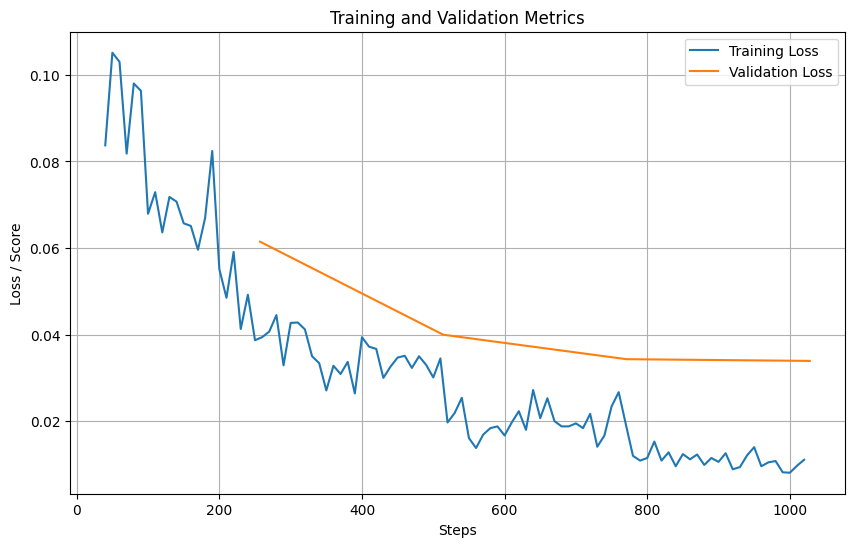

In [25]:
# Extract loss history
history = trainer.state.log_history
train_loss = []
eval_loss = []
train_steps = []
eval_steps = []
spearman = []
accuracy = []
combined_score = []
spearman_steps = []

for entry in history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])
    if 'eval_spearman' in entry:
        spearman.append(entry['eval_spearman'])
        accuracy.append(entry['eval_accuracy'])
        combined_score.append(entry['eval_combined_score'])
        spearman_steps.append(entry['step'])

        

#remove first two point (usually very high due to initialization)
if len(train_loss) > 3:
    train_loss = train_loss[3:]
    train_steps = train_steps[3:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
# plt.plot(spearman_steps, spearman, label='Spearman score')
# plt.plot(spearman_steps, accuracy, label='Accuracy')
# plt.plot(spearman_steps, combined_score, label='Combined Score')
plt.xlabel('Steps')
plt.ylabel('Loss / Score')
plt.title('Training and Validation Metrics')
plt.grid()
plt.legend()
plt.show()

In [26]:
# Generate predictions on dev set
predictions = trainer.predict(tokenized_dev)
preds = predictions.predictions.squeeze()

# Prepare for scoring.py
output_data = []
for idx, pred in zip(df_dev['id'], preds):
    # Rescale
    rescaled_pred = float(pred) * 5.0 + 0.5
    # Clamp prediction between 0.5 and 5.5
    final_pred = max(0.5, min(5.5, rescaled_pred))
    output_data.append({"id": str(idx), "prediction": final_pred})

output_file = f"{OUTPUT_DIR}/predictions.jsonl"
with open(output_file, "w") as f:
    for item in output_data:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_file}")

# Create dev_gold.jsonl for scoring
gold_data = []
for idx, row in df_dev.iterrows():
    # scoring.py expects 'label' to be the list of choices/ratings?
    # Wait, scoring.py: get_average(get_gold_by_id(...)["label"])
    # So "label" should be the list of ratings.
    # In train.json/dev.json, this is "choices".
    gold_data.append({"id": str(idx), "label": row["choices"]})

gold_file = f"{OUTPUT_DIR}/ref.jsonl"
with open(gold_file, "w") as f:
    for item in gold_data:
        f.write(json.dumps(item) + "\n")

print(f"Gold data saved to {gold_file}")

# Run scoring script
# TODO: Have OUTPUT_DIR to not hardcode the path here
!python ../score/scoring.py ../deberta-finetune-2/ref.jsonl ../deberta-finetune-2/predictions.jsonl ../deberta-finetune-2/score.json

Predictions saved to ../deberta-finetune-2/predictions.jsonl
Gold data saved to ../deberta-finetune-2/ref.jsonl
Importing...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Starting Scoring script...
['{"id": "500", "prediction": 0.93243408203125}\n', '{"id": "541", "prediction": 0.98797607421875}\n']
Everything looks OK. Evaluating file ../deberta-finetune-2/predictions.jsonl on ../deberta-finetune-2/ref.jsonl
----------
Spearman Correlation: 0.6926265071521445
Spearman p-Value: 3.397673748660915e-85
----------
Accuracy: 0.8231292517006803 (484/588)
Results dumped into scores.json successfully.
----------
Spearman Correlation: 0.6926265071521445
Spearman p-Value: 3.397673748660915e-85
----------
Accuracy: 0.8231292517006803 (484/588)
Results dumped into scores.json successfully.
